In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn

In [2]:
x, y = make_moons(n_samples= 1000, noise= 0.2)


Text(0, 0.5, 'x_2')

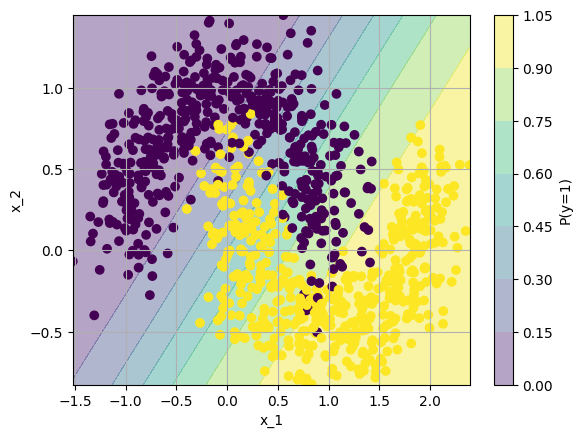

In [3]:
w1 = 2.1
w2 = -2.1
b = -0.2

x1 = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
x2 = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 100)
xx1 , xx2 = np.meshgrid(x1, x2)
yy = w1*xx1 + w2 * xx2 +b
zz = 1.0/(1.0+np.exp(-yy))

c = plt.contourf(xx1,xx2, zz, alpha=0.4)
plt.clim(0,1)
plt.scatter(x[:,0], x[:,1], c=y)
plt.colorbar(c, label='P(y=1)')

plt.grid('on')
plt.xlabel("x_1")
plt.ylabel("x_2")

# Praca domowa


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Krok 1: Generowanie i podział danych
# Tworzymy syntetyczny zbiór danych: 1000 próbek, 20 cech, 1 klasa docelowa (0 lub 1)
X, y = make_moons(n_samples=1000, noise=0.2)

# Dzielimy dane na zbiór treningowy (60%) i tymczasowy (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Dzielimy zbiór tymczasowy na walidacyjny (50% z 40% = 20%) i testowy (50% z 40% = 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Wyświetlamy rozmiary utworzonych zbiorów, aby się upewnić, że wszystko jest w porządku
print(f"Rozmiar zbioru treningowego: {X_train.shape[0]} próbek")
print(f"Rozmiar zbioru walidacyjnego: {X_val.shape[0]} próbek")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} próbek")


Rozmiar zbioru treningowego: 600 próbek
Rozmiar zbioru walidacyjnego: 200 próbek
Rozmiar zbioru testowego: 200 próbek


In [5]:
# # Tworzenie siatki punktów do wizualizacji
x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
x1_grid = np.linspace(x1_min, x1_max, 100)
x2_grid = np.linspace(x2_min, x2_max, 100)
xx1, xx2 = np.meshgrid(x1_grid, x2_grid)
# Przygotowanie siatki dla modelu PyTorch
grid_points = torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float32)

In [6]:
import torch

# Konwertujemy tablice NumPy na tensory PyTorch
# Używamy .float() do konwersji na typ zmiennoprzecinkowy
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1, 1) # Zmieniamy kształt y na [n_samples, 1]

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1, 1)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1, 1)


In [7]:
import torch.nn as nn
import torch.optim as optim

# Krok 3: Budowa modelu
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        # Definiujemy warstwy, podobnie jak w Keras
        self.layer1 = nn.Linear(input_size, 32)
        self.batch1 = nn.BatchNorm1d(32)
        self.layer2 = nn.Linear(32, 16)
        self.batch2 = nn.BatchNorm1d(16)
        self.layer3 = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Definiujemy przepływ danych przez sieć (forward pass)
        x = self.relu(self.batch1(self.layer1(x)))
        x = self.relu(self.batch2(self.layer2(x)))
        x = self.sigmoid(self.layer3(x)) # Sigmoid dla klasyfikacji binarnej
        return x

# Inicjalizacja modelu, funkcji straty i optymalizatora
input_features = X_train.shape[1]
model = SimpleNet(input_size=input_features)
print("Architektura modelu:\n", model)

# Funkcja straty dla klasyfikacji binarnej (Binary Cross-Entropy)
criterion = nn.BCELoss()
# Optymalizator Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Krok 4: Trenowanie modelu
epochs = 20
batch_size = 32

print("\nRozpoczynanie treningu sieci...")

for epoch in range(epochs):
    model.train() # Ustawienie modelu w tryb treningowy
    
    # Pętla po batchach (mini-paczkach) danych
    for i in range(0, len(X_train_tensor), batch_size):
        # Pobranie batcha
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # 1. Forward pass: obliczenie predykcji
        y_pred = model(X_batch)

        # 2. Obliczenie straty
        loss = criterion(y_pred, y_batch)

        # 3. Backward pass: obliczenie gradientów
        optimizer.zero_grad() # Zerowanie gradientów z poprzedniej iteracji
        loss.backward()

        # 4. Aktualizacja wag
        optimizer.step()

    # Walidacja na koniec każdej epoki
    model.eval() # Ustawienie modelu w tryb ewaluacji
    with torch.no_grad(): # Wyłączamy obliczanie gradientów na czas walidacji
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        
        # Obliczanie dokładności
        predicted = (val_outputs > 0.5).float()
        accuracy = (predicted == y_val_tensor).float().mean()
        
    print(f"Epoka {epoch+1}/{epochs}, Strata: {loss.item():.4f}, Strata walidacyjna: {val_loss.item():.4f}, Dokładność walidacyjna: {accuracy:.4f}")

print("Trening zakończony.")


Architektura modelu:
 SimpleNet(
  (layer1): Linear(in_features=2, out_features=32, bias=True)
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (batch2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Rozpoczynanie treningu sieci...
Epoka 1/20, Strata: 0.5712, Strata walidacyjna: 0.6323, Dokładność walidacyjna: 0.7950
Epoka 2/20, Strata: 0.4970, Strata walidacyjna: 0.5314, Dokładność walidacyjna: 0.8900
Epoka 3/20, Strata: 0.4333, Strata walidacyjna: 0.4558, Dokładność walidacyjna: 0.9150
Epoka 4/20, Strata: 0.3848, Strata walidacyjna: 0.4037, Dokładność walidacyjna: 0.9200
Epoka 5/20, Strata: 0.3439, Strata walidacyjna: 0.3619, Dokładność walidacyjna: 0.9200
Epoka 6/20, Strata: 0.3118, Strata walidacyjna: 0.3319, Dokładność walidacyjna: 0.9200

In [8]:
# Krok 5: Odczytanie wag modelu
print("\nOdczytywanie wag po treningu:")

# `state_dict()` zwraca słownik z wagami i biasami
for name, param in model.state_dict().items():
    print(f"Warstwa: {name}, Kształt: {param.shape}")
    # print(param) # Odkomentuj, aby zobaczyć wartości



Odczytywanie wag po treningu:
Warstwa: layer1.weight, Kształt: torch.Size([32, 2])
Warstwa: layer1.bias, Kształt: torch.Size([32])
Warstwa: batch1.weight, Kształt: torch.Size([32])
Warstwa: batch1.bias, Kształt: torch.Size([32])
Warstwa: batch1.running_mean, Kształt: torch.Size([32])
Warstwa: batch1.running_var, Kształt: torch.Size([32])
Warstwa: batch1.num_batches_tracked, Kształt: torch.Size([])
Warstwa: layer2.weight, Kształt: torch.Size([16, 32])
Warstwa: layer2.bias, Kształt: torch.Size([16])
Warstwa: batch2.weight, Kształt: torch.Size([16])
Warstwa: batch2.bias, Kształt: torch.Size([16])
Warstwa: batch2.running_mean, Kształt: torch.Size([16])
Warstwa: batch2.running_var, Kształt: torch.Size([16])
Warstwa: batch2.num_batches_tracked, Kształt: torch.Size([])
Warstwa: layer3.weight, Kształt: torch.Size([1, 16])
Warstwa: layer3.bias, Kształt: torch.Size([1])


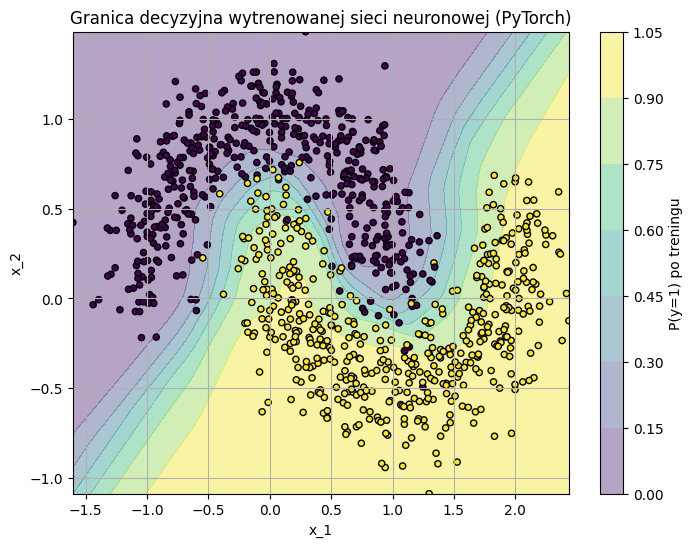

In [9]:
# Przewidywanie prawdopodobieństw dla każdego punktu na siatce
model.eval() # Ustawienie modelu w tryb ewaluacji
with torch.no_grad(): # Wyłączenie obliczania gradientów
    zz_tensor = model(grid_points)

# Wizualizacja granicy decyzyjnej
plt.figure(figsize=(8, 6))
c = plt.contourf(xx1, xx2, zz_tensor.numpy().reshape(xx1.shape), alpha=0.4)
plt.clim(0, 1) # Ustawienie zakresu kolorów dla prawdopodobieństw
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k') # Nanoszenie oryginalnych punktów danych
plt.colorbar(c, label='P(y=1) po treningu')

plt.grid('on')
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.title('Granica decyzyjna wytrenowanej sieci neuronowej (PyTorch)')
plt.show()

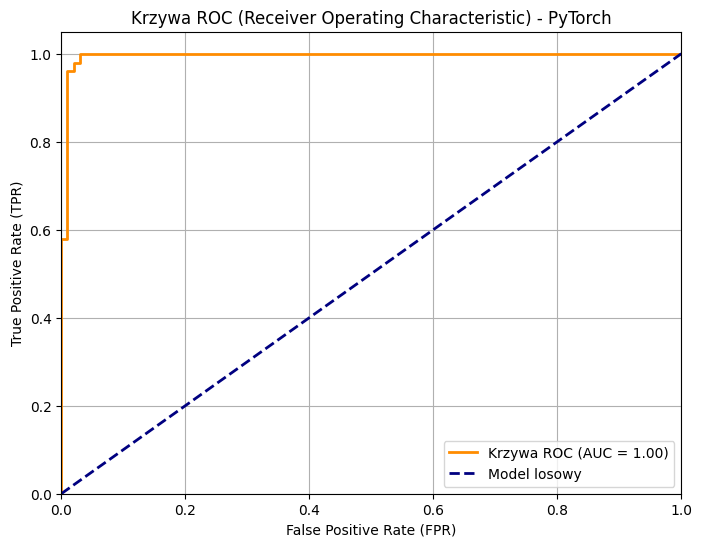


Ostateczna ocena na zbiorze testowym:
Strata (Loss): 0.1270
Dokładność (Accuracy): 0.9750


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Krok 6: Generowanie i rysowanie krzywej ROC
model.eval() # Upewniamy się, że model jest w trybie ewaluacji

with torch.no_grad(): # Wyłączamy gradienty
    # Uzyskujemy prawdopodobieństwa dla zbioru testowego
    y_pred_proba = model(X_test_tensor).numpy()

# Obliczamy punkty krzywej ROC (używamy oryginalnych etykiet NumPy)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Obliczamy pole pod krzywą (AUC)
roc_auc = auc(fpr, tpr)

# Rysowanie wykresu
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Model losowy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Krzywa ROC (Receiver Operating Characteristic) - PyTorch')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Ostateczna ocena na zbiorze testowym
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    predicted = (test_outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()

print(f"\nOstateczna ocena na zbiorze testowym:")
print(f"Strata (Loss): {test_loss.item():.4f}")
print(f"Dokładność (Accuracy): {accuracy.item():.4f}")
